### **Feature selection and model training**:

**Objective**: This notebook shows the model selection and training process. As an extra step, it is important to clarify that the data are queried from the database.

---

#### **First Step**: Querying data from the database deployed in Render 

Task:
- Establish connection to the database
- Extract data in pandas dataframe format using the connector that I designed

In [1]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import pearsonr
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Add the 'src' folder to sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from connections.db import DB

db = DB()

INFO:root:Database credentials loaded successfully.


In [3]:
data = db.fetch_as_dataframe('SELECT * FROM transformed_data;')

INFO:root:✔ Connected to database
INFO:root:✔ Data loaded into DataFrame
INFO:root:✔ Cursor closed
INFO:root:✔ Connection closed


---

#### **Second Step**: Features selection based on EDA results

Task:
- Perform the separation of the X variables and the target variable (Y).
- Perform 70/30 sampling for training and testing.

In [4]:
data.columns

Index(['Happiness_Rank', 'Country', 'Happiness_Score', 'GDP_per_capita',
       'Freedom', 'Generosity', 'Perceptions_of_corruption', 'Year'],
      dtype='object')

![](../docs/plots/correlation_matrix.png)

> **🤔 Let's remember that...**
The correlation matrix is a useful tool to identify which features are more relevant to train a model. So, based on this, I will choose the input features. If you want to see more information, I invite you to review the notebook [`01_EDA.ipynb`](./01_EDA.ipynb)


In [5]:
# Set the features (X) and target variable (Y)
X = data[['Happiness_Rank',
          'GDP_per_capita',
          'Freedom',
          'Perceptions_of_corruption',
          ]]

Y = data['Happiness_Score']

In [6]:
# Separating the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Create a pipeline that includes scaling and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])


---

#### **Third Step**: Modeling, training and evaluation

Task:
- Create and train the model
- Evaluate the model using metrics 
- Export the model in a PKL file in `models/`.


In [7]:
# Train the pipeline
pipeline.fit(X_train, y_train)

# Predict values for the test set
y_pred = pipeline.predict(X_test)

In [8]:
# Model evaluation
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.9845091742845912
Mean Absolute Error (MAE): 0.10451403740149194
Mean Squared Error (MSE): 0.019343257799187396
Root Mean Squared Error (RMSE): 0.13908004098067916


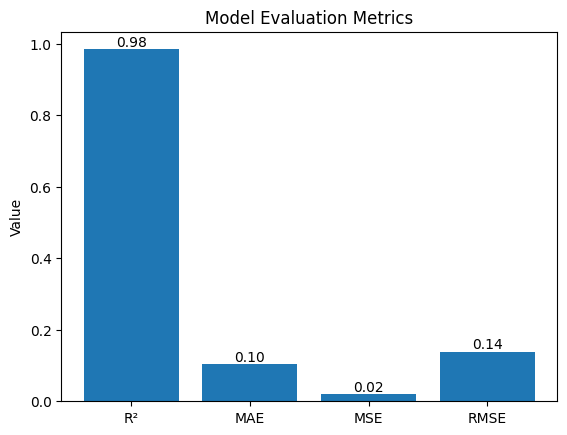

In [9]:
# Create a plot of the evaluation metrics
metrics = {
    'R²': r2,
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse
}

plt.bar(metrics.keys(), metrics.values())
plt.ylabel('Value')
plt.title('Model Evaluation Metrics')
for i, value in enumerate(metrics.values()):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')
plt.show()

In [10]:
# Export the model as a pickle file
output_paths = ['../models/00_happinesss_score_prediction_model.pkl', '../api/models/00_happinesss_score_prediction_model.pkl']

for path in output_paths:
    with open(path, 'wb') as file:
        pickle.dump(pipeline, file)

---